In [2]:
import numpy as np
import plotly.express as px 
import sklearn as sk
import copy 
import pandas as pd

In [3]:
path = '/kaggle/input/early-stage-diabetes-risk-prediction/diabetes_risk_prediction_dataset.csv'
df = pd.read_csv(path)

In [3]:
print(f'This dataset has {df.shape[0]} rows and {df.shape[1]} columns')
print('The first three rows of the dataset:')
df.head(n=3)

This dataset has 520 rows and 17 columns
The first three rows of the dataset:


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive


In [5]:
#Let's see if there are any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

Since the dataset has no missing values, we can start exploring it

In [7]:
px.histogram(df, x = "Age", title = 'Age distribution')

In [8]:
px.bar(df, x = 'class')

In [11]:
px.bar(df, x='class', color='Gender', title='Gender Ratio')

Since all the columns are categorical (exepct Age column). I'am going to use **dython**'s `associations` function to compute the correlation matrix. 


`associations(dataset, nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson', bias_correction=True, nan_strategy=_REPLACE, nan_replace_value=_DEFAULT_REPLACE_VALUE, ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None)`



It calculates the correlation/strength-of-association of features in the data-set with both categorical and continuous features using: **Pearson’s R for continuous-continuous** cases, **Correlation Ratio for categorical-continuous** cases, **Cramer’s V or Theil’s U for categorical-categorical** cases.

In [ ]:
pip install dython

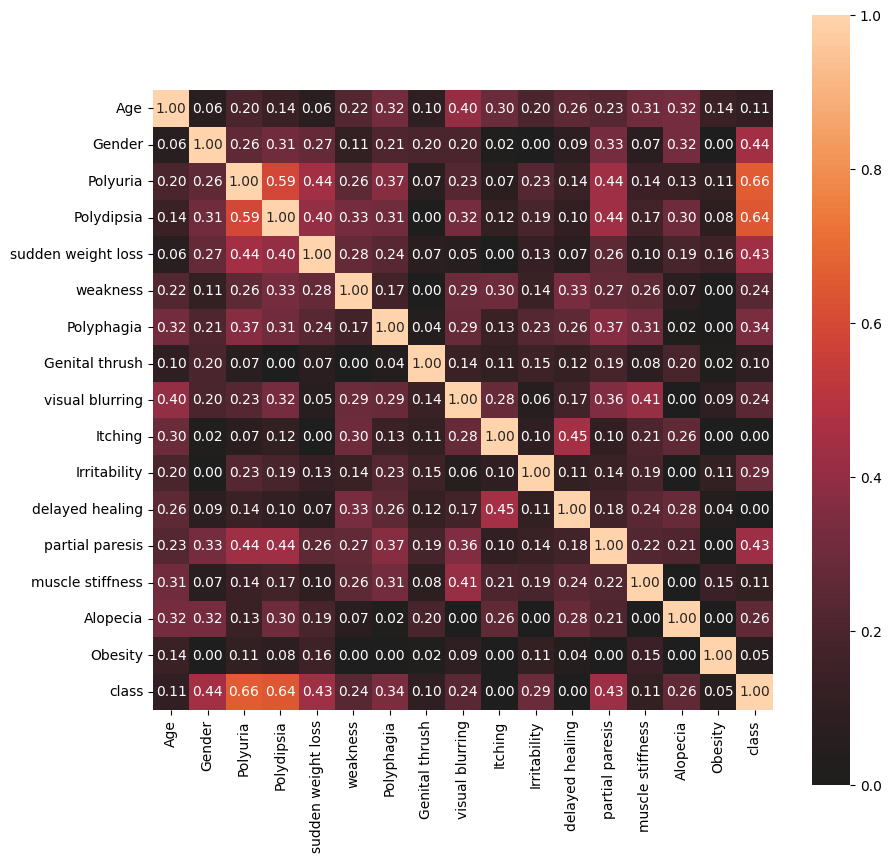

In [7]:
from dython.nominal import associations
#get categorical columns
categorical_columns = df.select_dtypes(include='object').columns.tolist()

corr_matrix = associations(df, nominal_columns= categorical_columns, numerical_columns= ['Age'], figsize = (10,10))['corr']

The most correlated feature with `class` are `Polyuria` and `Polydispsia`.  We can also see that `Obseity` is less correlated with having Diabetes. Which is suprising. Let's run some statistical tests.

In [63]:
px.bar(df, x='class', color='Obesity', title='Obesity Ratio')

The majority of people who have Diabetes are not Obeise!

In [8]:
#encode categorical variables to perform statstical test
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df_encoded.head(n=3)

,Age,Gender_Male,Polyuria_Yes,Polydipsia_Yes,sudden weight loss_Yes,weakness_Yes,Polyphagia_Yes,Genital thrush_Yes,visual blurring_Yes,Itching_Yes,Irritability_Yes,delayed healing_Yes,partial paresis_Yes,muscle stiffness_Yes,Alopecia_Yes,Obesity_Yes,class_Positive
0,40,True,False,True,False,True,False,False,False,True,False,True,False,True,True,True,True
1,58,True,False,False,False,True,False,False,True,False,False,False,True,False,True,False,True
2,41,True,True,False,False,True,True,False,False,True,False,True,False,True,True,False,True


In [9]:
inputs = df_encoded.drop('class_Positive', axis = 1)
output = df_encoded['class_Positive']
from sklearn.feature_selection import SelectKBest, chi2
feature_selector = SelectKBest(chi2, k = "all")
fit = feature_selector.fit(inputs,output)

p_values = pd.DataFrame(fit.pvalues_)
scores = pd.DataFrame(fit.scores_)
input_variable_names = pd.DataFrame(inputs.columns)
summary_stats = pd.concat([input_variable_names, p_values, scores], axis = 1)
summary_stats.columns = ["input_variable", "p_value", "chi2_score"]
summary_stats.sort_values(by = "p_value", inplace = True)
p_value_threshold = 0.05
score_threshold = 5

selected_variables = summary_stats.loc[(summary_stats["chi2_score"] >= score_threshold) &
                                       (summary_stats["p_value"] <= p_value_threshold)]
selected_variables = selected_variables["input_variable"].tolist()
selected_variables = [var[:var.index('_')] if var!= 'Age' else var for var in selected_variables]
fig1 = px.bar(summary_stats, x = summary_stats['input_variable'], y = summary_stats['p_value'])
fig2 = px.bar(summary_stats, x = summary_stats['input_variable'], y = summary_stats['chi2_score'])
fig1.show()
fig2.show()
print('The selected variables are', selected_variables)

The selected variables are ['Polydipsia', 'Polyuria', 'sudden weight loss', 'partial paresis', 'Gender', 'Irritability', 'Polyphagia', 'Alopecia', 'Age', 'visual blurring', 'weakness']


Based on these tests we select 11 amont the 16 initial input variables. 
We can also see that p_value(Obesity) = 0.13 > 0.05. Meaning the correlation is not significant. 

In [10]:
# for col in df_encoded.columns:
#     if col != 'Age':
#         df_encoded[col] = df_encoded[col].map({True: 1, False:0})
# df_encoded.columns = ['Age']+[var[:var.index('_')] for var in df_encoded.columns if var!='Age']
# df_encoded.head(n=3)


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1


In [12]:
#features and labels
X = df_encoded[selected_variables]
y = df_encoded['class']

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=42)

In [76]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
# scores = cross_val_score(clf, Xtrain, ytrain, cv=5, scoring='f1_macro')
clf = clf.fit(Xtrain, ytrain)
y_pred_train = clf.predict(Xtrain)
f1score_train = metrics.f1_score(ytrain, y_pred_train )

In [78]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(Xtest)
confusion_matrix = metrics.confusion_matrix(ytest, y_pred)
f1score = metrics.f1_score(y_pred, ytest)

In [87]:
clfs = {}
clfs['DecisionTrees'] = (1 - f1score_train, 1 - f1score)
print(f'Training set error: {1 - f1score_train}')
print(f'Test set error: {1 - f1score}' )
print(f'confusion matrix for decision tree is {confusion_matrix}')

Training set error: 0.0
Test set error: 0.04347826086956519
confusion matrix for decision tree is [[32  1]
 [ 5 66]]


In [14]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10)
rf = rf.fit(Xtrain, ytrain)
y_pred_train = rf.predict(Xtrain)
f1score_train = metrics.f1_score(ytrain, y_pred_train)

In [15]:
y_pred = rf.predict(Xtest)
confusion_matrix = metrics.confusion_matrix(ytest, y_pred)
f1score = metrics.f1_score(y_pred, ytest)

In [18]:
Xtrain.head(n=1)

,Polydipsia,Polyuria,sudden weight loss,partial paresis,Gender,Irritability,Polyphagia,Alopecia,Age,visual blurring,weakness
434,1,1,1,1,1,1,1,1,53,1,1


In [17]:
# clfs['RandomForest'] = (1 - f1score_train, 1 - f1score)
print(f'Training set error: {1 - f1score_train}')
print(f'Test set error: {1 - f1score}' )
print(f'confusion matrix for RandomForest is {confusion_matrix}')

Training set error: 0.002012072434607659
Test set error: 0.02898550724637694
confusion matrix for RandomForest is [[33  0]
 [ 4 67]]


The Random Forest works really good! FP is also really low. We can choose it as our classifier.

## Pipeline

In [96]:
def encoding(df):
    for col in df.columns:
        if col != 'Age':
            df[col] = df[col].map({'Yes': 1, 'No': 0})
    return df

In [111]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('Model', rf)
])

In [112]:
import joblib
joblib.dump(pipeline, 'early_stage_diabetes.pkl')

['early_stage_diabetes.pkl']